In [1]:
#read the reviews
import pandas as pd

data = pd.read_csv("IMDB_Dataset_label.csv")
data.sample(n=10)

,Unnamed: 0,review,sentiment,label
42618,42618,I had no real expectations going into this mov...,negative,0
23700,23700,"Semper Fi! I saw ""The D.I."" in 1957. Two-and-a...",positive,1
24222,24222,The most agile fat guy in martial arts does it...,positive,1
6710,6710,I found Darkness to be just too DARK. It had a...,negative,0
24694,24694,I have a deep liking for this film despite it ...,positive,1
31208,31208,"As with FOOTPRINTS (1975), I became aware of t...",positive,1
7359,7359,I'm just throwing in this review to show that ...,negative,0
18203,18203,It's a shame this movie didn't get more play i...,positive,1
37942,37942,I enjoyed the movie and Kellie Martins perform...,positive,1
41143,41143,This was a great 1981 film which had a great s...,positive,1


In [2]:
data.groupby('sentiment').describe()

Unnamed: 0                                                    \
               count         mean           std  min      25%      50%   
sentiment                                                                
negative     25000.0  24964.07768  14461.920812  3.0  12403.5  24940.0   
positive     25000.0  25034.92232  14406.028970  0.0  12577.0  25039.0   

                                label                                     
                75%      max    count mean  std  min  25%  50%  75%  max  
sentiment                                                                 
negative   37482.50  49999.0  25000.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
positive   37524.25  49995.0  25000.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0

In [3]:
data.sentiment.value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

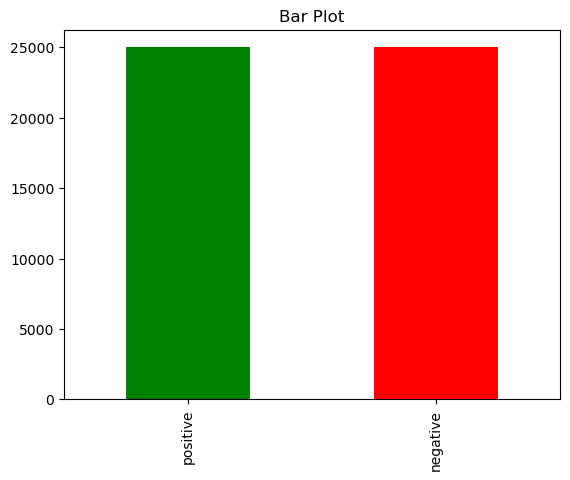

In [4]:
import matplotlib.pyplot as plt

count_Class=pd.value_counts(data["sentiment"], sort= True)
count_Class.plot(kind = 'bar',color = ["green","red"])
plt.title('Bar Plot')
plt.show()

In [5]:
neg_data  = data[data['label'] == 0].copy()
pos_data = data[data['label'] == 1].copy()

In [6]:
import wordcloud
from wordcloud import WordCloud
def show_wordcloud(df, title):
    text = ' '.join(df['review'].astype(str).tolist())
    stopwords = set(wordcloud.STOPWORDS)
    
    fig_wordcloud = wordcloud.WordCloud(stopwords=stopwords,background_color='lightgrey',
                    colormap='viridis', width=800, height=600).generate(text)
    
    plt.figure(figsize=(10,7), frameon=True)
    plt.imshow(fig_wordcloud)  
    plt.axis('off')
    plt.title(title, fontsize=20 )
    plt.show()

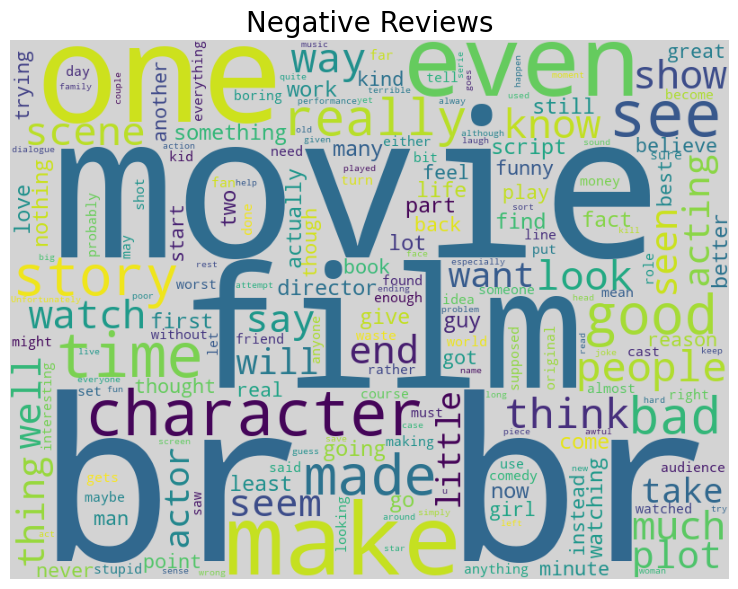

In [7]:
show_wordcloud(neg_data, "Negative Reviews")

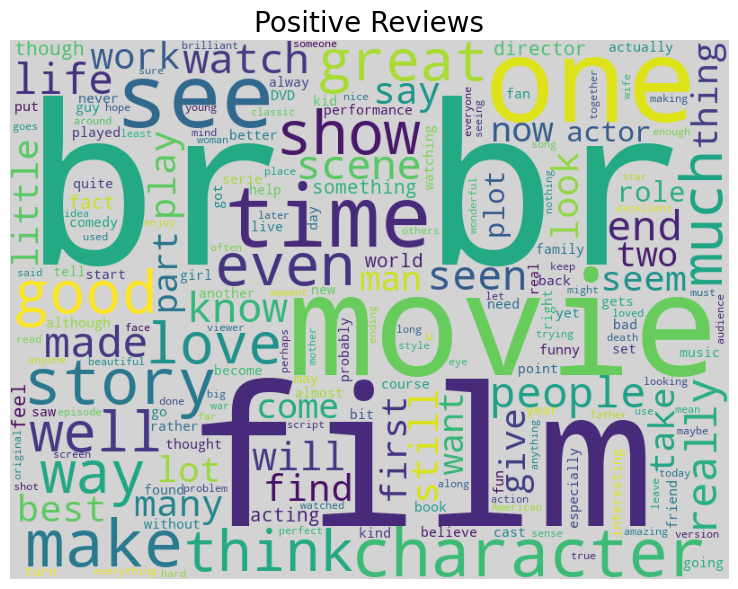

In [8]:
show_wordcloud(pos_data, "Positive Reviews")

In [9]:
# Keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from tensorflow.keras import utils
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
from collections import Counter
import time



In [10]:
# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 100
EPOCHS = 50
BATCH_SIZE = 256

# SENTIMENT
POSITIVE = "positive"
NEGATIVE = "negative"
NEUTRAL = "neutral"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
cbow_KERAS_MODEL = "cbow_Sentiment_lstm_w2v.sav"
cbow_WORD2VEC_MODEL = "cbow_model.w2v"
cbow_TOKENIZER_MODEL = "cbow_lstm_w2v_tokenizer.pkl"
cbow_ENCODER_MODEL = "cbow_encoder.pkl"

sg_KERAS_MODEL = "sg_Sentiment_lstm_w2v.sav"
sg_WORD2VEC_MODEL = "sg_model.w2v"
sg_TOKENIZER_MODEL = "sg_lstm_w2v_tokenizer.pkl"
sg_ENCODER_MODEL = "sg_encoder.pkl"


Text(0.5, 1.0, 'Dataset labels distribuition')

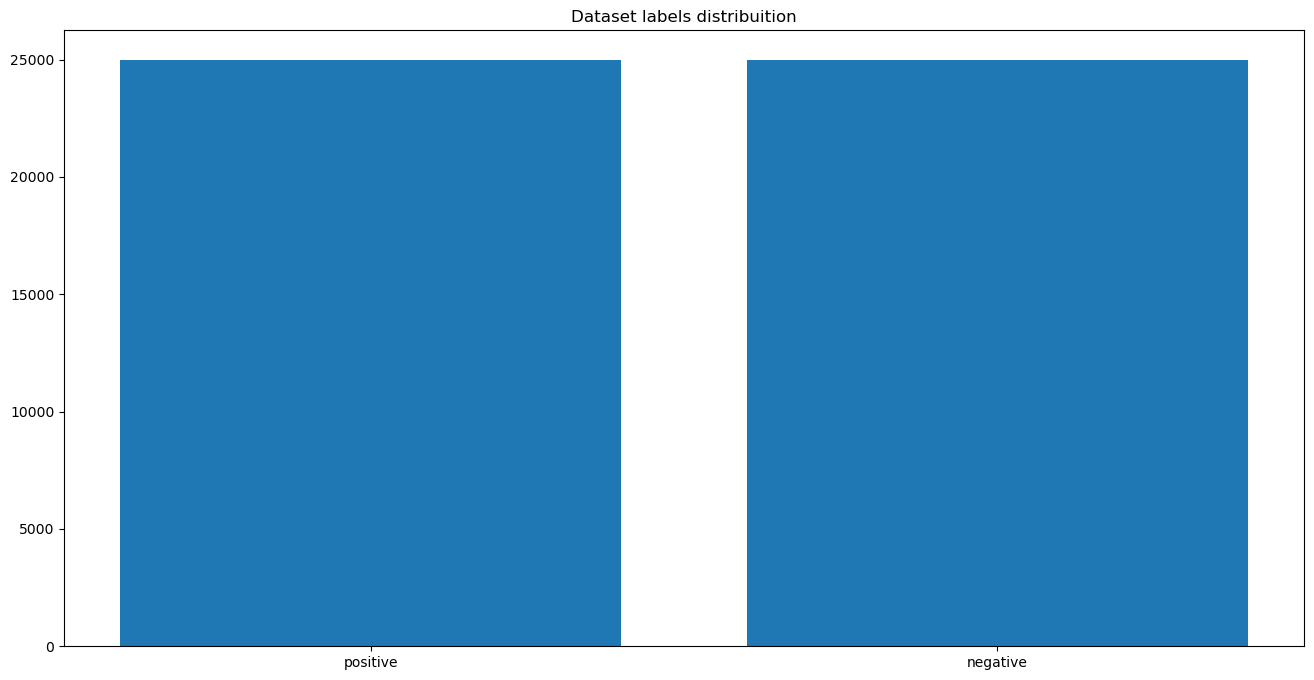

In [11]:
target_cnt = Counter(data.sentiment)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [12]:
# TEXT CLEANING
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

data.review = data.review.apply(lambda x: preprocess(x))
data.sample(10)

,Unnamed: 0,review,sentiment,label
14184,14184,ever wonder episode tuttle came middle first s...,positive,1
21175,21175,proof ever needed action movie irregardless bu...,negative,0
23791,23791,note budding film writers study film dialog re...,negative,0
9766,9766,love film songs story lines great fun song say...,positive,1
39919,39919,another example unique talents cary grant perf...,positive,1
30445,30445,shortage female flesh still interesting lenzi ...,negative,0
6831,6831,actually found favela rising via imdb website ...,positive,1
1859,1859,found writing review komodo vs cobra another m...,negative,0
34335,34335,young woman leaves provincial life new one cit...,positive,1
27584,27584,yet another example british cinema achieve sim...,positive,1


In [13]:
# split data into train and test set
from sklearn.model_selection import train_test_split

X = data['review'].values
y = data['sentiment'].values
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.20, random_state=42)
documents = [_text.split() for _text in data.review]

In [14]:

tokenizer = Tokenizer()
tokenizer.fit_on_texts(data.review)



In [15]:
vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 100947


In [16]:

x_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=SEQUENCE_LENGTH)

In [17]:
labels = data.sentiment.unique().tolist()
labels.append("neutral")
labels

['positive', 'negative', 'neutral']

In [18]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(data.sentiment.tolist())

y_train = encoder.transform(Y_train.tolist()) 
y_test = encoder.transform(Y_test.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (40000, 1)
y_test (10000, 1)


### Skipgram

In [19]:
# Train Word2Vec model
sg_w2vmodel = gensim.models.Word2Vec(documents, vector_size=W2V_SIZE,
                                     window=W2V_WINDOW, min_count=W2V_MIN_COUNT, workers=8, sg=1)


In [20]:
words = sg_w2vmodel.wv.index_to_key
sg_vocab_size_wv = len(words)
print("Vocab size:", sg_vocab_size_wv)

Vocab size: 28058


In [21]:
sg_w2vmodel.wv.most_similar("movie")

[('film', 0.7833203673362732),
 ('havent', 0.721485435962677),
 ('atleast', 0.714528501033783),
 ('couldnt', 0.7104820609092712),
 ('sequal', 0.6997584104537964),
 ('strangeland', 0.6976743936538696),
 ('hesitated', 0.6962960958480835),
 ('begining', 0.6937643885612488),
 ('summery', 0.6927812099456787),
 ('downsides', 0.6790610551834106)]

**Embedding layer**

In [22]:
sg_embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in sg_w2vmodel.wv:
    sg_embedding_matrix[i] = sg_w2vmodel.wv[word]
print(sg_embedding_matrix.shape)

(100947, 300)


In [23]:
sg_embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[sg_embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

**Build Model**

In [24]:
from tensorflow.keras.layers import Bidirectional

sg_model = Sequential()
sg_model.add(sg_embedding_layer)
sg_model.add(Dropout(0.5))
sg_model.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)))
sg_model.add(Dense(1, activation='sigmoid'))

sg_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 300)          30284100  
                                                                 
 dropout (Dropout)           (None, 100, 300)          0         
                                                                 
 bidirectional (Bidirectiona  (None, 128)              186880    
 l)                                                              
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 30,471,109
Trainable params: 187,009
Non-trainable params: 30,284,100
_________________________________________________________________


**Compile model**

In [25]:
sg_model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

**Callbacks**

In [26]:
sg_callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)] #change 'val_acc' to 'val_accuracy'

In [27]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

**Train**

Epoch 1/50
141/141 [==============================] - 241s 2s/step - loss: 0.4249 - accuracy: 0.8016 - val_loss: 0.3068 - val_accuracy: 0.8758 - lr: 0.0010
Epoch 2/50
141/141 [==============================] - 268s 2s/step - loss: 0.3328 - accuracy: 0.8561 - val_loss: 0.3511 - val_accuracy: 0.8700 - lr: 0.0010
Epoch 3/50
141/141 [==============================] - 250s 2s/step - loss: 0.3179 - accuracy: 0.8641 - val_loss: 0.3064 - val_accuracy: 0.8788 - lr: 0.0010
Epoch 4/50
141/141 [==============================] - 249s 2s/step - loss: 0.3093 - accuracy: 0.8673 - val_loss: 0.3025 - val_accuracy: 0.8717 - lr: 0.0010
Epoch 5/50
141/141 [==============================] - 250s 2s/step - loss: 0.3015 - accuracy: 0.8719 - val_loss: 0.2788 - val_accuracy: 0.8923 - lr: 0.0010
Epoch 6/50
141/141 [==============================] - 250s 2s/step - loss: 0.2932 - accuracy: 0.8744 - val_loss: 0.2700 - val_accuracy: 0.8915 - lr: 0.0010
Epoch 7/50
141/141 [==============================] - 250s 2s/st

INFO:tensorflow:Assets written to: sg_Sentiment_lstm_w2v.sav\assets


INFO:tensorflow:Assets written to: sg_Sentiment_lstm_w2v.sav\assets


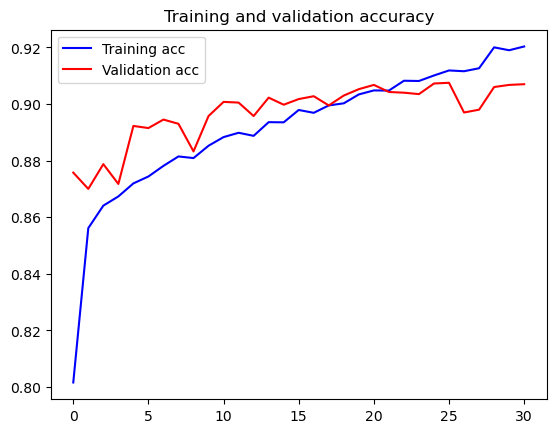

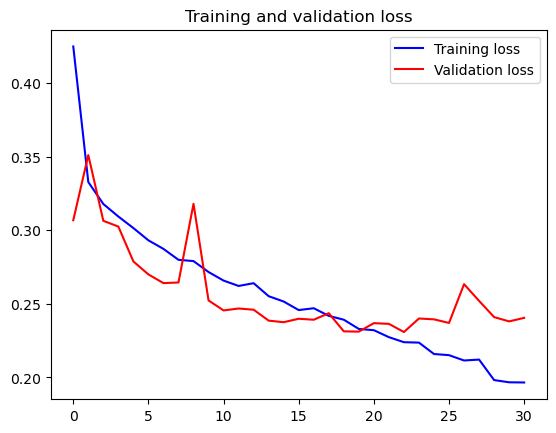

CPU times: total: 1h 7min 10s
Wall time: 2h 9min 56s


In [28]:
%%time
history = sg_model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=sg_callbacks)

import pickle

sg_model.save(sg_KERAS_MODEL)
sg_w2vmodel.save(sg_WORD2VEC_MODEL)
pickle.dump(tokenizer, open(sg_TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(sg_ENCODER_MODEL, "wb"), protocol=0)


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()



**Evaluate**

In [29]:
%%time
score = sg_model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

40/40 [==============================] - 13s 313ms/step - loss: 0.2322 - accuracy: 0.9080

ACCURACY: 0.9079999923706055
LOSS: 0.23219673335552216
CPU times: total: 4.61 s
Wall time: 12.6 s


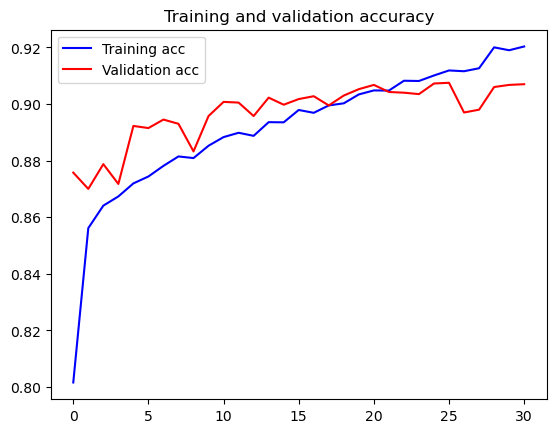

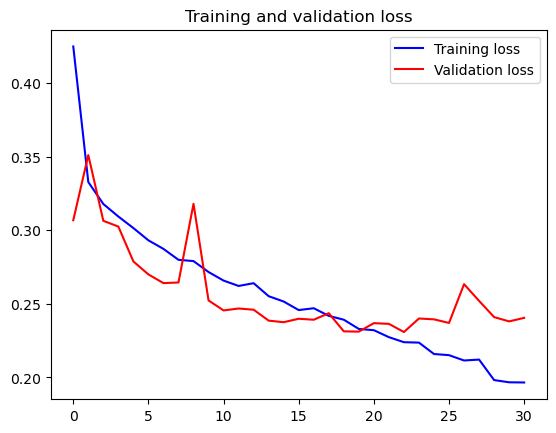

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

**Predict**

In [31]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [32]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = sg_model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}

In [33]:
predict("I think this is a very great movie.")

1/1 [==============================] - 0s 392ms/step


{'label': 'positive',
 'score': 0.9263175129890442,
 'elapsed_time': 0.429027795791626}

**Confusion Matrix**

In [34]:
%%time
y_pred_1d = []
y_test_1d = list(Y_test)
scores = sg_model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

2/2 [==============================] - 5s 1s/step
CPU times: total: 12.3 s
Wall time: 5.45 s


In [35]:
import itertools

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

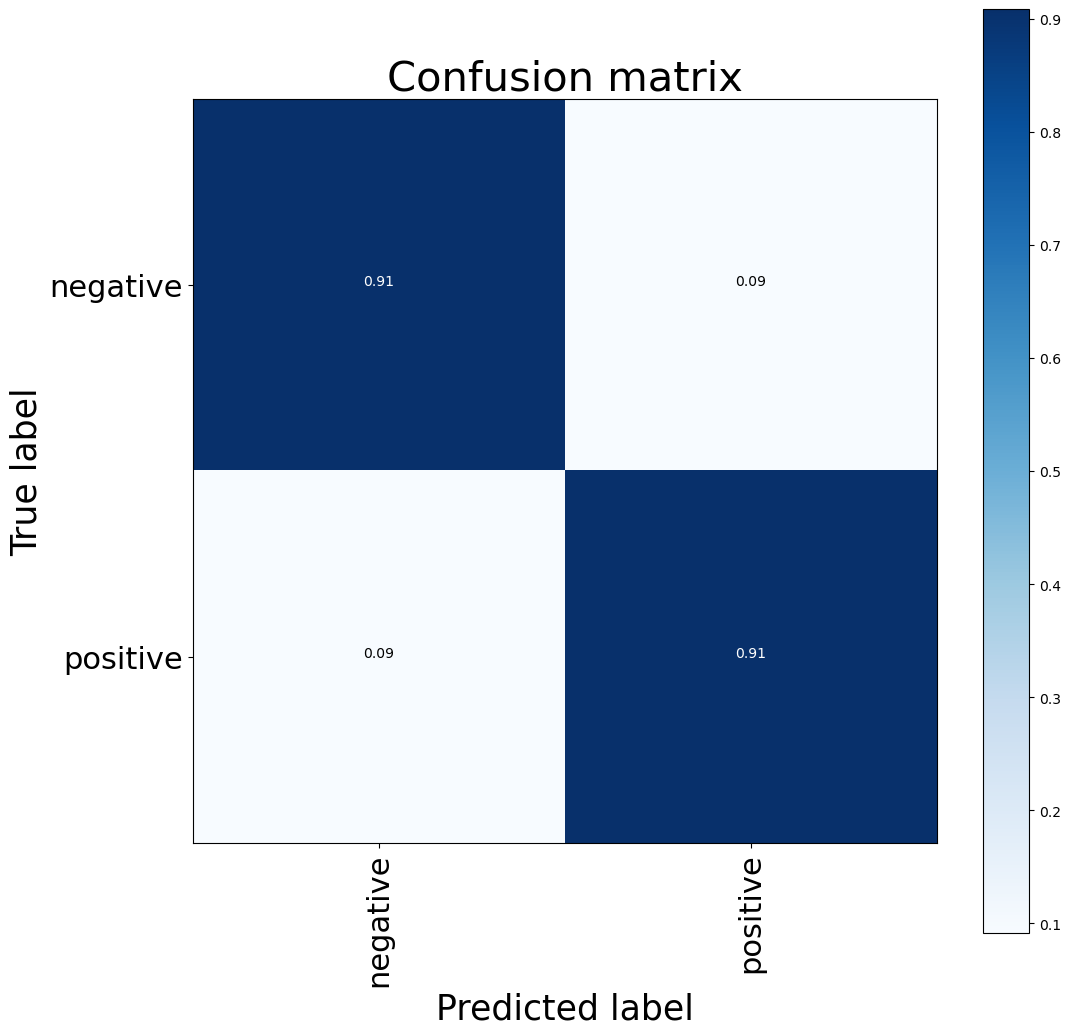

CPU times: total: 203 ms
Wall time: 337 ms


In [36]:
%%time
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=np.unique(Y_train), title="Confusion matrix")
plt.show()

**Classification Report**

In [37]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    negative       0.91      0.91      0.91      4961
    positive       0.91      0.91      0.91      5039

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



**Accuracy Score**

In [38]:
accuracy_score(y_test_1d, y_pred_1d)

0.908

**Save model**

In [60]:
import pickle

sg_model.save(f"{sg_KERAS_MODEL}")
sg_w2vmodel.save(f"{sg_WORD2VEC_MODEL}")
pickle.dump(tokenizer, open(f"{sg_TOKENIZER_MODEL}", "wb"), protocol=0)
pickle.dump(encoder, open(f"{sg_ENCODER_MODEL}", "wb"), protocol=0)

INFO:tensorflow:Assets written to: sg_Sentiment_lstm_w2v.sav\assets


INFO:tensorflow:Assets written to: sg_Sentiment_lstm_w2v.sav\assets


### CBOW

In [39]:
cbow_w2vmodel = gensim.models.Word2Vec(documents, vector_size=W2V_SIZE,
                                       window=W2V_WINDOW, min_count=W2V_MIN_COUNT, workers=8, sg=0)


In [40]:
words = cbow_w2vmodel.wv.index_to_key
cbow_vocab_size_wv = len(words)
print("Vocab size:", cbow_vocab_size_wv)

Vocab size: 28058


In [41]:
cbow_w2vmodel.wv.most_similar("movie")

[('film', 0.6641725301742554),
 ('movies', 0.6155877709388733),
 ('flick', 0.593931257724762),
 ('think', 0.48991188406944275),
 ('anyways', 0.4831670820713043),
 ('honestly', 0.482692688703537),
 ('thats', 0.4781149625778198),
 ('disappointed', 0.47800806164741516),
 ('sure', 0.4710519015789032),
 ('really', 0.4693973660469055)]

**Embedding layer**

In [42]:
cbow_embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in cbow_w2vmodel.wv:
    cbow_embedding_matrix[i] = cbow_w2vmodel.wv[word]
print(cbow_embedding_matrix.shape)

(100947, 300)


In [43]:
cbow_embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[cbow_embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

**Build Model**

In [44]:
from tensorflow.keras.layers import Bidirectional

cbow_model = Sequential()
cbow_model.add(cbow_embedding_layer)
cbow_model.add(Dropout(0.5))
cbow_model.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)))
cbow_model.add(Dense(1, activation='sigmoid'))

cbow_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 300)          30284100  
                                                                 
 dropout_1 (Dropout)         (None, 100, 300)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              186880    
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 30,471,109
Trainable params: 187,009
Non-trainable params: 30,284,100
_________________________________________________________________


**Compile model**

In [45]:
cbow_model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

**Callbacks**

In [46]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)] #change 'val_acc' to 'val_accuracy'

In [47]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

**Train**

Epoch 1/50
141/141 [==============================] - 281s 2s/step - loss: 0.4358 - accuracy: 0.7938 - val_loss: 0.3647 - val_accuracy: 0.8683 - lr: 0.0010
Epoch 2/50
141/141 [==============================] - 284s 2s/step - loss: 0.3395 - accuracy: 0.8554 - val_loss: 0.3240 - val_accuracy: 0.8808 - lr: 0.0010
Epoch 3/50
141/141 [==============================] - 283s 2s/step - loss: 0.3101 - accuracy: 0.8679 - val_loss: 0.3032 - val_accuracy: 0.8857 - lr: 0.0010
Epoch 4/50
141/141 [==============================] - 282s 2s/step - loss: 0.2970 - accuracy: 0.8754 - val_loss: 0.3196 - val_accuracy: 0.8810 - lr: 0.0010
Epoch 5/50
141/141 [==============================] - 283s 2s/step - loss: 0.2921 - accuracy: 0.8760 - val_loss: 0.3005 - val_accuracy: 0.8917 - lr: 0.0010
Epoch 6/50
141/141 [==============================] - 282s 2s/step - loss: 0.2804 - accuracy: 0.8832 - val_loss: 0.2850 - val_accuracy: 0.8898 - lr: 0.0010
Epoch 7/50
141/141 [==============================] - 282s 2s/st

INFO:tensorflow:Assets written to: cbow_Sentiment_lstm_w2v.sav\assets


INFO:tensorflow:Assets written to: cbow_Sentiment_lstm_w2v.sav\assets


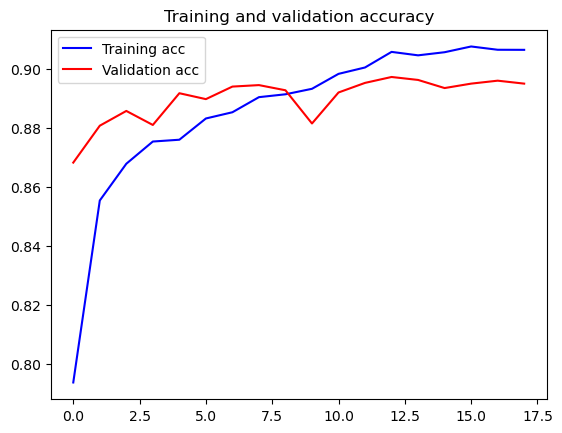

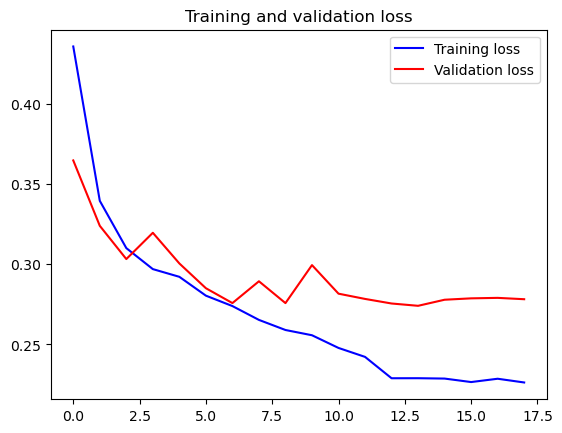

CPU times: total: 37min 48s
Wall time: 1h 24min 52s


In [48]:
%%time
history = cbow_model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

import pickle

cbow_model.save(cbow_KERAS_MODEL)
cbow_w2vmodel.save(cbow_WORD2VEC_MODEL)
pickle.dump(tokenizer, open(cbow_TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(cbow_ENCODER_MODEL, "wb"), protocol=0)


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()



**Evaluate**

In [49]:
%%time
score = cbow_model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

40/40 [==============================] - 16s 390ms/step - loss: 0.2668 - accuracy: 0.8980

ACCURACY: 0.8980000019073486
LOSS: 0.26680687069892883
CPU times: total: 4.67 s
Wall time: 15.8 s


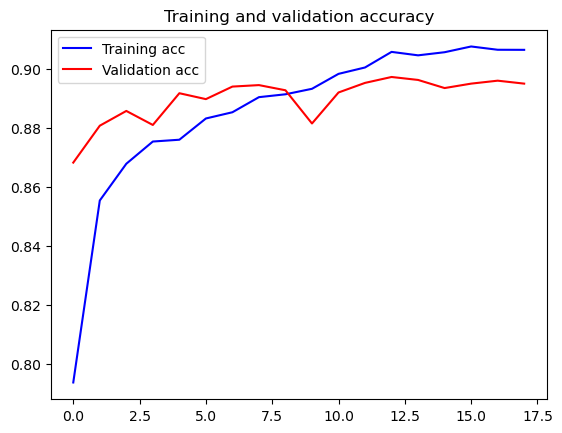

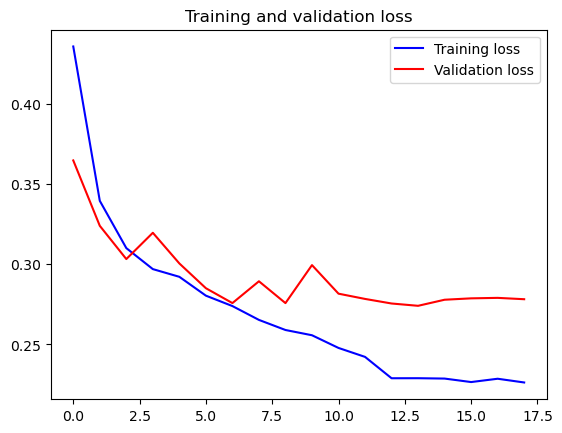

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

**Predict**

In [51]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [52]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = cbow_model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}

In [53]:
predict("I think this is a very great movie.")

1/1 [==============================] - 0s 377ms/step


{'label': 'positive',
 'score': 0.991209864616394,
 'elapsed_time': 0.39203476905822754}

**Confusion Matrix**

In [54]:
%%time
y_pred_1d = []
y_test_1d = list(Y_test)
scores = cbow_model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

2/2 [==============================] - 6s 1s/step
CPU times: total: 11.7 s
Wall time: 5.58 s


In [55]:
import itertools

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

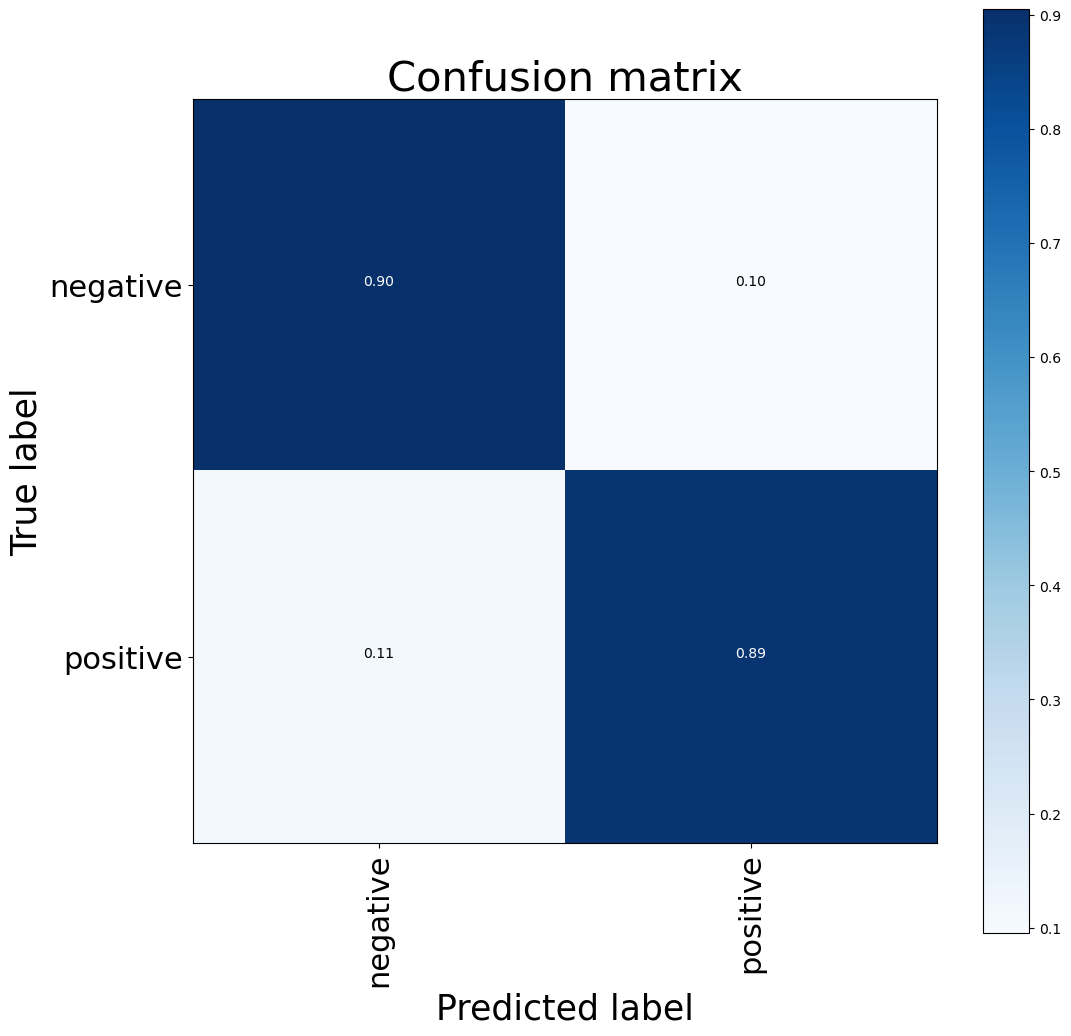

CPU times: total: 484 ms
Wall time: 690 ms


In [56]:
%%time
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=np.unique(Y_train), title="Confusion matrix")
plt.show()

**Classification Report**

In [57]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    negative       0.89      0.90      0.90      4961
    positive       0.90      0.89      0.90      5039

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



**Accuracy Score**

In [58]:
accuracy_score(y_test_1d, y_pred_1d)

0.898

**Save model**

In [59]:
import pickle

cbow_model.save(f"{cbow_KERAS_MODEL}")
cbow_w2vmodel.save(f"{cbow_WORD2VEC_MODEL}")
pickle.dump(tokenizer, open(f"{cbow_TOKENIZER_MODEL}", "wb"), protocol=0)
pickle.dump(encoder, open(f"{cbow_ENCODER_MODEL}", "wb"), protocol=0)

INFO:tensorflow:Assets written to: cbow_Sentiment_lstm_w2v.sav\assets


INFO:tensorflow:Assets written to: cbow_Sentiment_lstm_w2v.sav\assets
